<a href="https://colab.research.google.com/github/MuhammadRhakan/final_project/blob/main/2_Deployment_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install leidenalg igraph networkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 81.5 MB/s eta 0:00:00


In [2]:
import nltk
import kagglehub
import sys
import h5py
import random
import leidenalg
import json

import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import networkit as nk

from kagglehub.datasets import KaggleDatasetAdapter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, vstack
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")

/tmp/ipython-input-3-193580186.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")


In [4]:
#fill missing last update date
def fill_empty_date(data, features):
  data = data.copy()
  for col in features:
    data[col] = pd.to_datetime(data[col], utc=True)

  data[features[1]] = data[features[1]].fillna(data[features[0]])

  return data


#get latest 5 years data
def get_latest_five_years(data, features):
  data = data.copy()
  latest_year = data[features[0]].max().year
  last_five_year = latest_year - 5

  data = data[(data[features[0]].dt.year > last_five_year) & (data[features[1]].dt.year > last_five_year)]

  return data


#basic cleaning
def initial_cleaning_phase(course):
  course = course.copy()
  null_values = course[(course['num_lectures'] == 0) |
                (course['content_length_min'] == 0) |
                ((course['avg_rating'] == 0) & (course['num_reviews'] > 0))].index
  clean_data = course.drop(index=null_values).dropna()

  return clean_data

In [5]:
course = course[course['language'].isin({'English'})]
course = fill_empty_date(course, ['published_time', 'last_update_date'])
course = get_latest_five_years(course, ['published_time', 'last_update_date'])
course = initial_cleaning_phase(course)
print(course.shape)

(89225, 20)


In [6]:
#separate numeric and non-numeric attributes
def get_numerical_attributes(data, exclude):
  numerical = []
  print(f"Numerical Attributes:")
  for num in data.select_dtypes(include = 'number').drop(columns='id').columns:
    if num != exclude:
      numerical.append(num)
      print(f"• {num}")

  return numerical


#handle outliers using trim
def outlier_trimming(data, features, par, skip, fg1, fg2):
  data = data.copy()
  data.loc[data[skip] == 0, skip] = np.nan

  trim = data.copy()
  for col in features:
    outliers = data[col].quantile(par)
    trim = trim[trim[col] < outliers]

  transformed = trim.copy()
  transformed[fg1] = np.log1p(transformed[fg1])
  transformed[fg2] = np.sqrt(transformed[fg2])
  transformed[skip] = np.sqrt(transformed[skip])

  return trim, transformed


#label categorical values
def features_labeling(data, features):
  label = data.copy()

  label['rounded_rating'] = (label[features[1]].copy()).astype(int)
  label['rating_label'] = label['rounded_rating'].apply(lambda x: 'bad' if x < 3 else ('mid' if x == 3 else 'good'))

  return label


#check distributions
def box_visualization(data, features):
  sns.boxplot(data[features])
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [7]:
numerical = get_numerical_attributes(course, exclude='avg_rating')
course_completed = features_labeling(course, features=['is_paid','avg_rating'])

course_trim, course_trim_scaled = outlier_trimming(course_completed,
                                                   features=numerical,
                                                   par=0.9,
                                                   skip='price',
                                                   fg1=['num_subscribers', 'num_reviews', 'num_comments'],
                                                   fg2=['num_lectures', 'content_length_min'])

Numerical Attributes:
• price
• num_subscribers
• num_reviews
• num_comments
• num_lectures
• content_length_min


In [ ]:
def trace_item_index(data, feature):
  new_order = data[feature].reset_index()
  new_order = new_order.rename(columns={'index': 'Raw index', 'id': 'Item ID'})

  return new_order

indices = trace_item_index(course_trim, feature='id')
indices

,Raw index,Item ID
0,180,17704.0
1,1113,51648.0
2,1129,51942.0
3,1255,57585.0
4,1441,64734.0
...,...,...
52899,209724,4912840.0
52900,209725,4913148.0
52901,209727,4913922.0
52902,209729,4913954.0


In [8]:
def semantic_preprocessing(data, features, id):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  combined_text =[]
  for col in features:
    semantic = data[col].str.lower()
    semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]))
    combined_text.append(semantic)

  semantic = pd.concat(combined_text, axis=1).apply(lambda x: ' '.join(x), axis=1)

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  tfidf_df[id] = data[id].values
  tfidf_df = tfidf_df.set_index(id)

  return tfidf_matrix.toarray(), tfidf_df

In [9]:
def numerical_preprocessing(data, features, id):
  correlation_score = data[features].corr()
  upper = correlation_score.where(np.triu(np.ones(correlation_score.shape), k=1).astype(bool))
  redundant = [col for col in upper.columns if any(upper[col] > 0.85)]

  numeric = data[features].drop(columns=redundant)

  scaler = MinMaxScaler()
  normalized_matrix = scaler.fit_transform(numeric)
  normalized_df = pd.DataFrame(data=normalized_matrix, columns=numeric.columns)
  normalized_df[id] = data[id].values
  normalized_df = normalized_df.set_index(id)

  return normalized_matrix, normalized_df

In [10]:
def nominal_preprocessing(data, features, id):
  nominal = data[features].copy().reset_index(drop=True)

  for col in nominal.columns:
    if nominal[col].dtype == 'datetime64[ns, UTC]':
      nominal[col] = nominal[col].dt.year.astype(str)

  multiattribute_df = pd.get_dummies(nominal)
  multiattribute_matrix = multiattribute_df.values
  multiattribute_df[id] = data[id].values
  multiattribute_df = multiattribute_df.set_index(id)

  return multiattribute_matrix, multiattribute_df

In [11]:
semantic_matrix, semantic_df = semantic_preprocessing(course_trim, features=['title', 'headline', 'topic'], id='id')
numeric_matrix, numeric_df = numerical_preprocessing(course_trim_scaled, numerical, id='id')
nominal_matrix, nominal_df = nominal_preprocessing(course_trim, features=['is_paid', 'category', 'subcategory', 'rating_label', 'published_time', 'last_update_date'], id='id')

In [12]:
def feature_combination(*data, form):
  initial = data[0]
  for i in data[1:]:
    if form =='df':
      initial = pd.concat([initial, i], axis=1)
    elif form == 'matrix':
      initial = np.concatenate((initial, i), axis=1)
    else:
      raise ValueError("form must be 'df' or 'matrix'")

  combined = initial

  return combined

In [13]:
multiattribute_matrix = feature_combination(semantic_matrix, numeric_matrix, nominal_matrix, form='matrix')
multiattribute_df = feature_combination(semantic_df, numeric_df, nominal_df, form='df')

In [ ]:
print(f'Matrix shape: {multiattribute_matrix.shape}')
print(f'Matrix size: {sys.getsizeof(multiattribute_matrix)/1000000} MB')

Matrix shape: (52904, 1162)
Matrix size: 491.795712 MB


In [14]:
index_to_node = multiattribute_df.index.to_list()

In [15]:
def single_multiattributes_pipeline_batched(data, group, block_size=1000, output_path='multiattribute_similarity.h5'):
  N = len(data)

  semantic_block = data[:, slice(0, 1000)] #1000 vectorized semantic feature
  numeric_block = data[:, slice(1000, 1005)] # 5 original numerics
  nominal_block = data[:, slice(1005, 1162)] # 157 encoded categorical

  nominal_group_sizes = group

  with h5py.File(output_path, 'w') as f:
    sim_matrix = f.create_dataset('similarity', shape=(N, N), dtype='float32')

    for start in range(0, N, block_size):
      end = min(start + block_size, N)
      print(f"Processing block {start}:{end}")

      # 1. Semantic: block vs all
      semantic_block_part = semantic_block[start:end]
      semantic_sim = cosine_similarity(semantic_block_part, semantic_block)

      # 2. Numeric: block vs all
      numeric_block_part = numeric_block[start:end]
      numeric_dist = euclidean_distances(numeric_block_part, numeric_block)
      numeric_sim = 1 / (1 + numeric_dist)

      # 3. Nominal: multiple groups
      dice_sims = []
      start_col = 0
      for cols in nominal_group_sizes:
        end_col = start_col + cols
        nom_all = nominal_block[:, start_col:end_col]
        nom_part = nom_all[start:end, :]

        ni = nom_part.sum(axis=1)
        nj = nom_all.sum(axis=1)

        nij = nom_part @ nom_all.T

        denom = ni[:, None] + nj[None, :]
        denom[denom == 0] = 1e-12

        dice = (2 * nij) / denom
        dice_sims.append(dice)
        start_col = end_col

      # Combine similarities
      multiattribute_similarity = (semantic_sim + numeric_sim + sum(dice_sims)) / 8

      # Zero out lower triangle for symmetry (optional)
      for i in range(end - start):
        abs_row = start + i
        multiattribute_similarity[i, :abs_row] = 0.0

      # Write to HDF5
      sim_matrix[start:end, :] = multiattribute_similarity

  print(f"Done! Similarity matrix saved in: {output_path}")

In [16]:
single_multiattributes_pipeline_batched(multiattribute_matrix, group=[1, 13, 130, 3, 5, 5])

Processing block 0:1000
Processing block 1000:2000
Processing block 2000:3000
Processing block 3000:4000
Processing block 4000:5000
Processing block 5000:6000
Processing block 6000:7000
Processing block 7000:8000
Processing block 8000:9000
Processing block 9000:10000
Processing block 10000:11000
Processing block 11000:12000
Processing block 12000:13000
Processing block 13000:14000
Processing block 14000:15000
Processing block 15000:16000
Processing block 16000:17000
Processing block 17000:18000
Processing block 18000:19000
Processing block 19000:20000
Processing block 20000:21000
Processing block 21000:22000
Processing block 22000:23000
Processing block 23000:24000
Processing block 24000:25000
Processing block 25000:26000
Processing block 26000:27000
Processing block 27000:28000
Processing block 28000:29000
Processing block 29000:30000
Processing block 30000:31000
Processing block 31000:32000
Processing block 32000:33000
Processing block 33000:34000
Processing block 34000:35000
Process

In [ ]:
def load_similarity_matrix(file_path):
  with h5py.File(file_path, 'r') as f:
    sim_matrix = f['similarity'][:]

In [ ]:
def similarity_samples(file_path, top_k=30):
  with h5py.File(file_path, 'r') as f:
    similarity_matrix = f['similarity'][:]

  num_items = similarity_matrix.shape[0]

  top_k_neighbors = {}
  for i in range(num_items):
    sims = similarity_matrix[i]
    indices = np.argsort(sims)[::-1]
    indices = indices[indices != i]

    ego_id = index_to_node[i]
    neighbors = []
    for j in indices[:top_k]:
        neighbor_id = index_to_node[j]
        neighbors.append([int(neighbor_id), float(sims[j])])

    top_k_neighbors[str(ego_id)] = neighbors

  with open("top_k_neighbors.json", "w") as f:
    json.dump(top_k_neighbors, f)

  return top_k_neighbors

similarity_samples('multiattribute_similarity.h5')

In [20]:
def incremental_network_graph_model_hdf5(h5_file, threshold):
  G = nx.Graph()

  with h5py.File(h5_file, 'r') as f:
    sim_matrix = f['similarity']
    N = sim_matrix.shape[0]

    G.add_nodes_from(index_to_node)

    for i in range(N):
      row = sim_matrix[i, i+1:]  # read only needed slice
      indices = (row >= threshold).nonzero()[0]
      for idx in indices:
        j = i + 1 + idx  # correct absolute column index
        node_i = index_to_node[i]
        node_j = index_to_node[j]

        if not nx.has_path(G, node_i, node_j):
            G.add_edge(node_i, node_j, weight=row[idx])

  print(f"Number of nodes: {G.number_of_nodes()}")
  print(f"Number of edges: {G.number_of_edges()}")

  return G

In [19]:
G = incremental_network_graph_model_hdf5('multiattribute_similarity.h5', threshold=0.75)

Number of nodes: 52904
Number of edges: 2044067


In [21]:
G_raw = incremental_network_graph_model_hdf5('multiattribute_similarity.h5', threshold=0.75)

Number of nodes: 52904
Number of edges: 52567


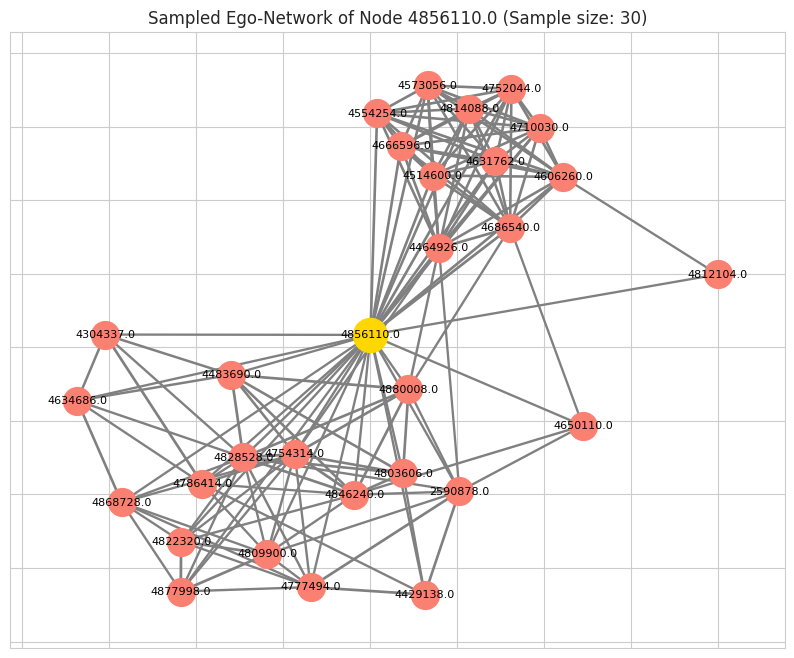

In [24]:
def network_graph_sampling(G, central_node, sample_size=50):
  if central_node is None:
    degrees = dict(G.degree())
    central_node = max(degrees, key=degrees.get)
    print(f"Central node: {central_node}, degree: {degrees[central_node]}")

  ego = nx.ego_graph(G, central_node, radius=1)
  nodes_in_ego = list(ego.nodes())

  if sample_size >= len(nodes_in_ego):
    sampled_neighbors  = nodes_in_ego
  else:
    sampled_neighbors  = random.sample(nodes_in_ego, sample_size-1)

  sampled_nodes = [central_node] + sampled_neighbors
  sampled_ego = ego.subgraph(sampled_nodes)

  edge_weights = [ego[u][v].get('weight', 1.0) for u, v in sampled_ego.edges()]
  max_weight = max(edge_weights) if edge_weights else 1.0
  widths = [2 * (w / max_weight) for w in edge_weights]  # scale factor for visibility

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(sampled_ego, seed=42)
  other_nodes = [n for n in sampled_ego.nodes() if n != central_node]
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=other_nodes,
                          node_color='salmon',
                          node_size=400,
                          label='Neighbors')
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=[central_node],
                          node_color='gold',
                          node_size=600,
                          label='Central Node')
  nx.draw_networkx_edges(sampled_ego, pos,
                          width=widths,
                          edge_color='gray')
  nx.draw_networkx_labels(sampled_ego, pos, font_size=8)
  plt.title(f"Sampled Ego-Network of Node {central_node} (Sample size: {len(sampled_nodes)})")
  plt.show()

network_graph_sampling(G, central_node=random.choice(index_to_node), sample_size=30)

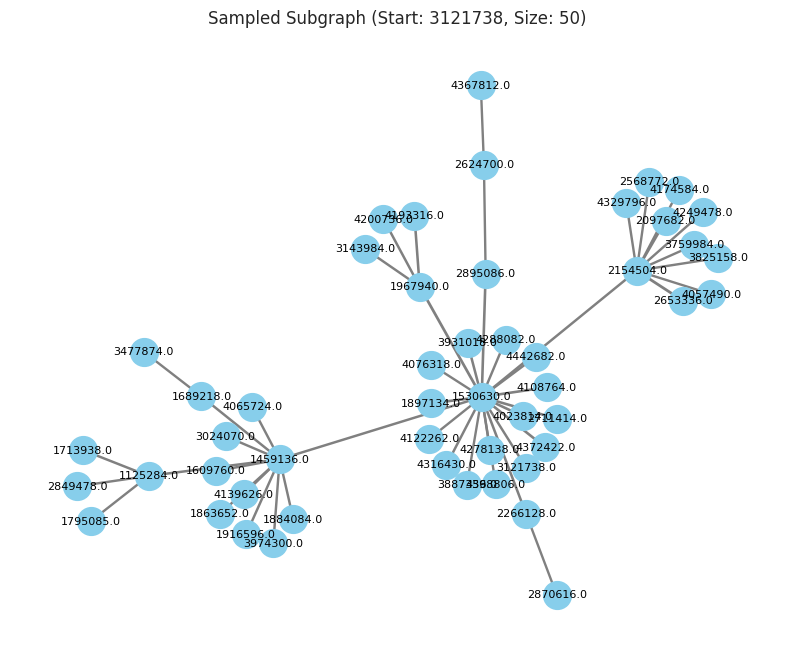

In [45]:
def network_graph_sampling_bfs(G, sample_size=50, start_node=None):
  if start_node is None:
    start_node = random.choice(list(G.nodes()))
    # print(f"Start node (randomly selected): {int(start_node)}")

  # Use BFS to collect up to `sample_size` nodes
  visited = set()
  queue = [start_node]

  while queue and len(visited) < sample_size:
    node = queue.pop(0)
    if node not in visited:
      visited.add(node)
      neighbors = list(G.neighbors(node))
      random.shuffle(neighbors)
      queue.extend([n for n in neighbors if n not in visited])

  sampled_nodes = list(visited)
  sampled_subgraph = G.subgraph(sampled_nodes)

  # Prepare edge weights for styling
  edge_weights = [G[u][v].get('weight', 1.0) for u, v in sampled_subgraph.edges()]
  max_weight = max(edge_weights) if edge_weights else 1.0
  widths = [2 * (w / max_weight) for w in edge_weights]

  # Plotting
  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(sampled_subgraph, seed=42)
  nx.draw_networkx_nodes(sampled_subgraph, pos,
                          node_color='skyblue',
                          node_size=400)
  nx.draw_networkx_edges(sampled_subgraph, pos,
                          width=widths,
                          edge_color='gray')
  nx.draw_networkx_labels(sampled_subgraph, pos, font_size=8)
  plt.title(f"Sampled Subgraph (Start: {int(start_node)}, Size: {len(sampled_nodes)})")
  plt.axis('off')
  plt.show()

network_graph_sampling_bfs(G_raw, sample_size=50, start_node=None)

In [47]:
def plot_interactive_network(G, save_path="network_graph.html", max_nodes=500):
    # If too large, take the largest connected component
    if G.number_of_nodes() > max_nodes:
        print(f"Graph too large ({G.number_of_nodes()} nodes), sampling largest connected component...")
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    pos = nx.spring_layout(G, seed=42)  # consistent layout

    # Edge traces
    edge_x = []
    edge_y = []
    edge_weights = []
    for u, v, data in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_weights.append(data.get('weight', 1.0))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines'
    )

    # Node traces
    node_x = []
    node_y = []
    node_text = []
    node_color = []
    degrees = dict(G.degree())

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"Node: {node}<br>Degree: {degrees[node]}")
        node_color.append(degrees[node])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            color=node_color,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
            line_width=2)
    )

    # Final figure
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=f"Interactive Network Graph ({G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges)",
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                annotations=[dict(
                    text="Use scroll to zoom and drag to move",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002
                )],
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False)
            )
    )

    # Save and open in browser
    fig.write_html(save_path)
    print(f"Interactive graph saved to {save_path}")

plot_interactive_network(G, save_path="my_network_graph.html", max_nodes=1000)

Graph too large (52904 nodes), sampling largest connected component...
Interactive graph saved to my_network_graph.html


In [ ]:
def network_graph_sampling_plotly(G, central_node=None, sample_size=50):
    if central_node is None:
        degrees = dict(G.degree())
        central_node = max(degrees, key=degrees.get)
        print(f"Central node: {central_node}, degree: {degrees[central_node]}")

    ego = nx.ego_graph(G, central_node, radius=1)
    nodes_in_ego = list(ego.nodes())

    if sample_size >= len(nodes_in_ego):
        sampled_neighbors = nodes_in_ego
    else:
        sampled_neighbors = random.sample(nodes_in_ego, sample_size - 1)

    sampled_nodes = [central_node] + sampled_neighbors
    sampled_ego = ego.subgraph(sampled_nodes)

    pos = nx.spring_layout(sampled_ego, seed=42)

    edge_traces = []
    edge_weights = []
    for u, v in sampled_ego.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        weight = sampled_ego[u][v].get('weight', 1.0)
        edge_weights.append(weight)

    edge_weights = np.array(edge_weights)
    norm_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)
    cmap = plt.cm.Blues(norm_weights)

    for i, (u, v) in enumerate(sampled_ego.edges()):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        color = f"rgba({cmap[i][0]*255:.0f},{cmap[i][1]*255:.0f},{cmap[i][2]*255:.0f},{cmap[i][3]:.2f})"
        edge_traces.append(go.Scatter(
            x=[x0, x1],
            y=[y0, y1],
            mode='lines',
            line=dict(width=2, color=color),
            hoverinfo='text',
            text=[f'{u} ⇄ {v}<br>Weight: {edge_weights[i]:.2f}'],
            showlegend=False
        ))

    node_x = []
    node_y = []
    node_color = []
    node_text = []
    node_sizes = []
    for node in sampled_ego.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        degree = sampled_ego.degree[node]
        node_color.append(degree)
        node_sizes.append(20 if node == central_node else 12)
        label = f"<b>{node}</b>" if node == central_node else str(node)
        node_text.append(f"Node {node}<br>Degree: {degree}")

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        textposition='top center',
        hoverinfo='text',
        text=[str(n) if n != central_node else f'<b>{n}</b>' for n in sampled_ego.nodes()],
        marker=dict(
            showscale=True,
            colorscale='YlOrRd',
            color=node_color,
            size=node_sizes,
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
            line_width=2
        ),
        hovertext=node_text,
        showlegend=False
    )

    fig = go.Figure(
        data=edge_traces + [node_trace],
        layout=go.Layout(
            title=f"<b>Sampled Ego-Network of Node {central_node}</b><br>Sample Size: {len(sampled_nodes)}",
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[dict(
                text="Edge color represents weight<br>Central node shown in gold with bold label",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002
            )],
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False)
        )
    )

    fig.show()


network_graph_sampling_plotly(G, central_node=random.choice(index_to_node), sample_size=30)

In [ ]:
def leiden_community_detection(G, partition_type):
  G_igraph = ig.Graph.from_networkx(G)
  partition = leidenalg.find_partition(G_igraph, partition_type)
  print(f"Number of communities: {len(partition)}")

  modularity_scores = partition.modularity
  print(f"Modularity Score: {modularity_scores:.3f}")

  community_size = Counter(partition.membership)
  top_communities = [com for com, size in community_size.items() if size > 10]

leiden_community_detection(G, leidenalg.ModularityVertexPartition)

Number of communities: 381
Modularity Score: 0.947


In [ ]:
def leiden_community_detection(G, partition_type):
    # G is the NetworkX graph

    G_igraph = ig.Graph.from_networkx(G) # Convert NetworkX to igraph
    partition = leidenalg.find_partition(G_igraph, partition_type)
    print(f"Number of communities: {len(partition)}")

    modularity_score = partition.modularity
    print(f"Modularity Score: {modularity_score:.3f}")

    community_sizes = Counter(partition.membership)
    print("Community sizes (Top 10):", dict(community_sizes.most_common(10)))
    print(f"Communities with size > 10: {[com for com, size in community_sizes.items() if size > 10]}")

    # --- Intra-community Similarity ---
    print("\n--- Intra-community Similarity ---")
    intra_community_similarities = {}
    for community_id in set(partition.membership):
        # Correctly get igraph node indices for this community
        igraph_nodes_in_community_indices = [i for i, comm_id in enumerate(partition.membership) if comm_id == community_id]

        # Convert igraph node indices back to NetworkX node names using G_igraph.vs
        nx_nodes_in_community = [G_igraph.vs[idx]['_nx_name'] for idx in igraph_nodes_in_community_indices]

        if len(nx_nodes_in_community) < 2:
            intra_community_similarities[community_id] = 0.0
            continue

        # Now, work with the NetworkX graph G
        community_subgraph = G.subgraph(nx_nodes_in_community)

        # Collect all edge weights within this community from the NetworkX subgraph
        weights_within_community = [data['weight'] for u, v, data in community_subgraph.edges(data=True) if 'weight' in data]

        if weights_within_community:
            intra_community_similarities[community_id] = np.mean(weights_within_community)
        else:
            intra_community_similarities[community_id] = 0.0

    # Sort communities by their intra-community similarity for better readability
    sorted_intra_sim = sorted(intra_community_similarities.items(), key=lambda item: item[1], reverse=True)
    print("Average Intra-community Similarities (Top 10 communities):")
    for comm_id, avg_sim in sorted_intra_sim[:10]:
        print(f"  Community {comm_id}: {avg_sim:.4f} (Size: {community_sizes[comm_id]})")

    overall_avg_intra_sim = np.mean(list(intra_community_similarities.values())) if intra_community_similarities else 0.0
    print(f"\nOverall Average Intra-community Similarity: {overall_avg_intra_sim:.4f}")


    # --- Inter-community Similarity ---
    print("\n--- Inter-community Similarity ---")
    inter_community_similarities = []

    community_ids = list(set(partition.membership))
    if len(community_ids) < 2:
        print("Not enough communities to calculate inter-community similarity.")
        return

    for i in range(len(community_ids)):
        for j in range(i + 1, len(community_ids)):
            comm1_id = community_ids[i]
            comm2_id = community_ids[j]

            igraph_nodes_in_comm1_indices = [k for k, comm_id in enumerate(partition.membership) if comm_id == comm1_id]
            igraph_nodes_in_comm2_indices = [k for k, comm_id in enumerate(partition.membership) if comm_id == comm2_id]

            # Convert igraph node indices back to NetworkX node names
            nx_nodes_in_comm1 = [G_igraph.vs[idx]['_nx_name'] for idx in igraph_nodes_in_comm1_indices]
            nx_nodes_in_comm2 = [G_igraph.vs[idx]['_nx_name'] for idx in igraph_nodes_in_comm2_indices]

            weights_between_communities = []
            for u, v, data in G.edges(data=True): # Iterate edges of the original NetworkX graph G
                if 'weight' in data:
                    if (u in nx_nodes_in_comm1 and v in nx_nodes_in_comm2) or \
                       (u in nx_nodes_in_comm2 and v in nx_nodes_in_comm1):
                        weights_between_communities.append(data['weight'])

            if weights_between_communities:
                inter_community_similarities.append(np.mean(weights_between_communities))

    if inter_community_similarities:
        overall_avg_inter_sim = np.mean(inter_community_similarities)
        print(f"Overall Average Inter-community Similarity: {overall_avg_inter_sim:.4f}")
    else:
        print("No edges found between different communities, or not enough communities.")

leiden_community_detection(G, leidenalg.ModularityVertexPartition)

Number of communities: 381
Modularity Score: 0.947
Community sizes (Top 10): {0: 2343, 1: 1897, 2: 1875, 3: 1800, 4: 1797, 5: 1692, 6: 1552, 7: 1550, 8: 1462, 9: 1462}
Communities with size > 10: [37, 14, 10, 32, 13, 6, 5, 49, 43, 48, 7, 18, 11, 31, 44, 20, 41, 26, 1, 8, 15, 19, 36, 9, 4, 55, 30, 46, 12, 3, 23, 50, 34, 38, 2, 33, 28, 45, 25, 24, 29, 42, 47, 27, 21, 0, 16, 54, 22, 35, 53, 40, 17, 51, 39, 52]

--- Intra-community Similarity ---
Average Intra-community Similarities (Top 10 communities):
  Community 88: 0.9302 (Size: 2)
  Community 60: 0.8934 (Size: 4)
  Community 107: 0.8913 (Size: 2)
  Community 87: 0.8830 (Size: 2)
  Community 101: 0.8668 (Size: 2)
  Community 76: 0.8655 (Size: 2)
  Community 115: 0.8619 (Size: 2)
  Community 105: 0.8585 (Size: 2)
  Community 70: 0.8554 (Size: 3)
  Community 73: 0.8546 (Size: 3)

Overall Average Intra-community Similarity: 0.2584

--- Inter-community Similarity ---


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-38-1661535813.py", line 87, in <cell line: 0>
    leiden_community_detection(G, leidenalg.ModularityVertexPartition)
  File "/tmp/ipython-input-38-1661535813.py", line None, in leiden_community_detection
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 110

In [ ]:
def centrality_metrics_networkit(G_nx):
    # Convert to NetworKit graph
    G_nk = nk.nxadapter.nx2nk(G_nx)

    deg = np.array(nk.centrality.DegreeCentrality(G_nk).run().scores())
    clo = np.array(nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED).run().scores())
    bet = np.array(nk.centrality.Betweenness(G_nk, normalized=True).run().scores())
    avg = [(d + c + b) / 3 for d, c, b in zip(deg, clo, bet)]

    def minmax_normalization(x):
        return (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x)

    deg_norm = deg / (G_nk.numberOfNodes() - 1)
    clo_norm = minmax_normalization(clo)
    bet_norm = bet
    avg_norm = (deg_norm + clo_norm + bet_norm) / 3

    centrality_df = pd.DataFrame({
        "item": list(G_nx.nodes()),
        "degree": deg,
        "degree_normalized": deg_norm,
        "closeness": clo,
        "closeness_normalized": clo_norm,
        "betweenness": bet,
        "betweenness_normalized": bet_norm,
        "average_centrality": avg,
        "average_centrality_normalized": avg_norm,
    })

    centrality_df.to_csv("centrality_full_raw.csv", index=False)

centrality_metrics_networkit(G_raw)

In [48]:
def recommendation_phase(data, id, ego, top_n=10, normalized=True, verbose=True):
  with open("top_k_neighbors.json") as f:
    top_k_neighbors = json.load(f)

  centrality_df = pd.read_csv("centrality_full.csv", dtype={'item': int})
  centrality_df.set_index("item", inplace=True)
  candidates = top_k_neighbors.get(str(ego), [])

  suffix = "_normalized" if normalized else ""
  col_AC = f"average_centrality{suffix}"
  col_DC = f"degree{suffix}"
  col_CC = f"closeness{suffix}"
  col_BC = f"betweenness{suffix}"

  CEF_records = []
  for neighbor, _ in candidates:
    neighbor = int(neighbor)
    try:
      distance = nx.shortest_path_length(G, source=int(ego), target=neighbor)
      if distance > 0:
        ac = centrality_df.at[neighbor, col_AC]
        cef = ac / distance
        CEF_records.append({
          "id": neighbor,
          "CEF": cef,
          "links": distance,
          "DC": centrality_df.at[neighbor, col_DC],
          "BC": centrality_df.at[neighbor, col_BC],
          "CC": centrality_df.at[neighbor, col_CC]
        })
    except (nx.NetworkXNoPath, KeyError):
        continue

  cef_df = pd.DataFrame(CEF_records)
  cef_df = cef_df.sort_values(by="CEF", ascending=False).head(top_n)
  result = data.merge(cef_df, how="inner", on="id")

  if verbose and not data[data[id] == ego].empty:
      ego_row = data[data[id] == ego].iloc[0]
      print(f'⭐ \033[1mCourse Title\033[0m\t\t: {ego_row["title"]}')
      print(f'📌 Category\t\t: {ego_row["category"]}')
      print(f'➡️ Subcategory\t\t: {ego_row["subcategory"]}\n')

      # print(f"✅ Top {top_n} recommendations for ego {int(ego)}:")
      # for _, row in result.iterrows():
      #     print(f"Item {row['id']} — CEF: {row['CEF']:.6f}, links: {row['links']}")

  return result[['id', 'title', 'category', 'subcategory', 'DC', 'BC', 'CC', 'links', 'CEF']]

In [ ]:
recommendation_phase(course, id='id', ego=random.choice(index_to_node), top_n=10, verbose=True)

⭐ Course Title		: Learn Spanish Level 4: Present progressive verbs in Spanish
📌 Category		: Teaching & Academics
➡️ Subcategory		: Language Learning



,id,title,category,subcategory,DC,BC,CC,links,CEF
0,4203080.0,Cantonese for beginners,Teaching & Academics,Language Learning,0.007315,0.000068,0.978609,1,0.328664
1,4234724.0,Business English Mastermind - Useful Expressio...,Teaching & Academics,Language Learning,0.008071,0.000011,0.965904,1,0.324662
2,4270232.0,Bosnian/Serbian/ Croatian for beginners,Teaching & Academics,Language Learning,0.006918,0.000025,0.970023,1,0.325656
3,4277030.0,4. Romanian grammar: The Noun,Teaching & Academics,Language Learning,0.007599,0.000019,0.971641,1,0.326420
4,4279558.0,5. Romanian grammar: Present Tense,Teaching & Academics,Language Learning,0.007542,0.000015,0.970457,1,0.326005
5,4288922.0,"English Grammar-All Levels: pronouns, sentence...",Teaching & Academics,Language Learning,0.008544,0.000007,0.956694,1,0.321748
6,4292594.0,"Learn British English Vocab, Slang, Pronunciat...",Teaching & Academics,Language Learning,0.009168,0.000040,0.995000,1,0.334736
7,4307935.0,The Latin Adjectives: An Introduction,Teaching & Academics,Language Learning,0.006956,0.000053,0.969826,1,0.325612
8,4386016.0,How to create simple sentences in basic hindi ...,Teaching & Academics,Language Learning,0.006729,0.000036,0.959307,1,0.322024
9,4405448.0,Learn English With A TEFL Tutor: Master Parts ...,Teaching & Academics,Language Learning,0.008884,0.000019,0.971246,1,0.326716


In [49]:
recommendation_phase(course, id='id', ego=random.choice(index_to_node), top_n=10, verbose=True)

⭐ Course Title		: Yoga Doctor's Exercise with Minimal Movement
📌 Category		: Health & Fitness
➡️ Subcategory		: General Health



,id,title,category,subcategory,DC,BC,CC,links,CEF
0,2564252.0,Read a CBD lab report,Health & Fitness,General Health,0.000586,0.000003,0.443118,1,0.147902
1,2576232.0,Reduce Aches & Pains with Full Body Mobility R...,Health & Fitness,General Health,0.000662,0.000016,0.451679,1,0.150786
2,2582892.0,How to Assess the Shoulder for Therapists,Health & Fitness,General Health,0.000605,0.000002,0.438787,1,0.146465
3,2593806.0,Learn Everything About Essential Oils,Health & Fitness,General Health,0.000662,0.000004,0.428908,1,0.143191
4,2608908.0,Kalarippayattu warm up exercises Part I,Health & Fitness,Martial Arts & Self Defense,0.001002,0.000025,0.461560,1,0.154196
5,2610240.0,YOGA FOR EVERYONE,Health & Fitness,Yoga,0.000737,0.000003,0.458925,1,0.153222
6,2619918.0,Pregnancy Nutrition & Lifestyle,Health & Fitness,General Health,0.000624,0.000002,0.433379,1,0.144668
7,2622474.0,How to activate your glutes with in depth exer...,Health & Fitness,Fitness,0.000473,0.000002,0.441588,1,0.147354
8,2650490.0,Kundalini Yoga - Take a deep breath and stress...,Health & Fitness,Yoga,0.000756,0.000003,0.459025,1,0.153261
9,2717072.0,Qigong for Fibromyalgia,Health & Fitness,General Health,0.001021,0.000034,0.534594,2,0.089275
